<a href="https://colab.research.google.com/github/alfredoaguiararce/prediccion-de-covid-con-keras/blob/main/modelo_covid19_rx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **RED NEURONAL CONVOLUCIONAL (MODELO DEEP LEARNING)**
---
> Diagnóstico de Covid19 vía clasificación de imágenes de rayos X de Tórax aplicando Transfer Learning*

> *Dataset tomado de*: https://github.com/ieee8023/covid-chestxray-dataset.git y https://data.mendeley.com/datasets/rscbjbr9sj/2



---



 ## **INICIO**
---

**Seteando Tensorflow 1.x:**

In [2]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


**Montando Google Drive:**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Obteniendo el dataset en formato .zip**

In [4]:
%%bash
cd "/content/drive/My Drive/COVID_19/dataset"

# validar si dataset (zip) existe y descargar
FILE=covid19_dataset.zip
if [ ! -f "$FILE" ]; then
    echo "Archivo $FILE no existe --> Descargando ..."
    gdown --id 1ohGQU6g79aWB6WEf-QQUfPGf1sE4favu
fi

# borrar carpetas train y test antes de descomprimir
rm -rf train test

# descomprimir dataset (zip) en carpetas train y test
unzip -qq covid19_dataset.zip 

**Visualizando imágenes del dataset:**

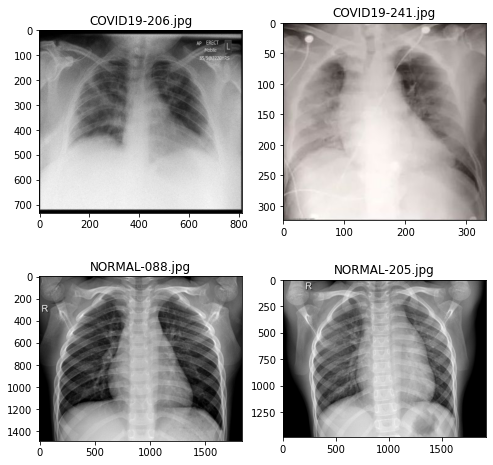

In [5]:
import os
import shutil
import glob
import numpy as np
from random import randrange

from keras.preprocessing import image
import matplotlib.pyplot as plt

# Folder del proyecto
project_folder = "/content/drive/My Drive/COVID_19"

files_train_covid19 = glob.glob(project_folder+"/dataset/train/covid19/*.jpg")
files_test_covid19 = glob.glob(project_folder+"/dataset/test/covid19/*.jpg")
files_train_normal = glob.glob(project_folder+"/dataset/train/normal/*.jpg")
files_test_normal = glob.glob(project_folder+"/dataset/test/normal/*.jpg")

# Obteniendo imágenes al azar de cada folder
file_train_covid19 = files_train_covid19[randrange(len(files_train_covid19))]
image_train_covid19 = image.load_img(file_train_covid19)

file_test_covid19 = files_test_covid19[randrange(len(files_test_covid19))]
image_test_covid19 = image.load_img(file_test_covid19)

file_train_normal = files_train_normal[randrange(len(files_train_normal))]
image_train_normal = image.load_img(file_train_normal)

file_test_normal = files_test_normal[randrange(len(files_test_normal))]
image_test_normal = image.load_img(file_test_normal)

# Visualizando 4 imágenes
fig = plt.gcf()
fig.set_size_inches(8, 8)

plt.subplot(2,2,1)
plt.imshow(image_train_covid19)
plt.title(file_train_covid19.split("/")[-1])

plt.subplot(2,2,2)
plt.imshow(image_test_covid19)
plt.title(file_test_covid19.split("/")[-1])

plt.subplot(2,2,3)
plt.imshow(image_train_normal)
plt.title(file_train_normal.split("/")[-1])

plt.subplot(2,2,4)
plt.imshow(image_test_normal)
plt.title(file_test_normal.split("/")[-1])

plt.show()


 ## **SECCIÓN I - PREPROCESAMIENTO DE DATOS**
---

**Cargar dataset TRAIN y aplicar Data Augmentation:**

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Dimensión de las imgs a procesar
img_width = 224
img_height = 224
batch_size = 40

# Data Augmentation and Normalization
datagen_train = ImageDataGenerator(rescale=1.0/255.0,      # Normalizar los valores al rango [0-1]
                                   horizontal_flip=True,   # Giro horizontal
                                   rotation_range=15,      # Giro aleatorio (clockwise) entre 0 y 15 grados
                                   width_shift_range=0.15,  # Mover la img horizontelmente 15%
                                   height_shift_range=0.15, # Mover la img verticalmente 15%
                                   zoom_range=0.2)          # Zoom in / Zoom out aleatorio de 20% => 80% - 120%

# Leer imagenes del folder dataset/train
training_set_imgs = datagen_train.flow_from_directory(project_folder+"/dataset/train",
                                                      target_size = (img_width, img_height),
                                                      class_mode = 'binary',
                                                      classes = ['normal','covid19'],
                                                      batch_size = batch_size)
# Mostrando resultados
num_imgs_training = len(training_set_imgs.filenames)

print("\n")
print("Núm. de imgs ENTRENAMIENTO:", num_imgs_training)
print("Classes:", training_set_imgs.class_indices)
print("Núm. Classes [0]:", np.sum(training_set_imgs.labels == 0, axis=0))
print("Núm. Classes [1]:", np.sum(training_set_imgs.labels == 1, axis=0))

Found 352 images belonging to 2 classes.


Núm. de imgs ENTRENAMIENTO: 352
Classes: {'normal': 0, 'covid19': 1}
Núm. Classes [0]: 176
Núm. Classes [1]: 176


**Mostrando datos resultado de Data augmentation:**

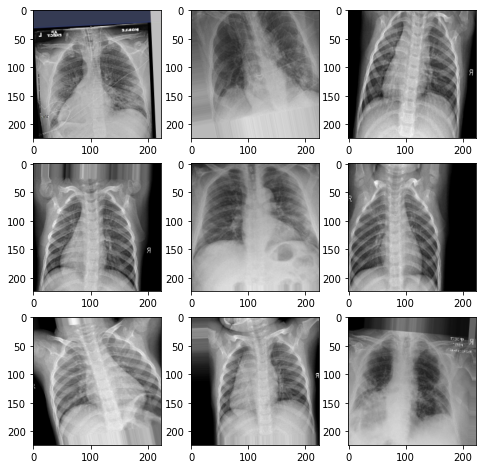

In [7]:
import copy 

# Visualizando data augmentation para 1 imagen
fig = plt.gcf()
fig.set_size_inches(8, 8)

it = copy.copy(training_set_imgs)

for i in range(9):
	plt.subplot(3,3,1 + i)
	batch = it.next()[0]
	imagenp = (batch[0]*255).astype('uint8')
	plt.imshow(imagenp)
plt.show()

**Cargar dataset TEST sin aplicar Data Augmentation:**

In [8]:
# Data Normalization
datagen_test = ImageDataGenerator(rescale=1.0/255.0)

# Leer imagenes del folder dataset/train
testing_set_imgs = datagen_test.flow_from_directory(project_folder+"/dataset/test",
                                                      target_size = (img_width, img_height),
                                                      class_mode = 'binary',
                                                      classes = ['normal','covid19'],
                                                      batch_size = batch_size,
                                                      shuffle=False)
# Mostrando resultados
num_imgs_testing = len(testing_set_imgs.filenames)

print("\n")
print("Núm. de imgs TEST:", num_imgs_testing)
print("Classes:", testing_set_imgs.class_indices)
print("Núm. Classes [0]:", np.sum(testing_set_imgs.labels == 0, axis=0))
print("Núm. Classes [1]:", np.sum(testing_set_imgs.labels == 1, axis=0))

Found 88 images belonging to 2 classes.


Núm. de imgs TEST: 88
Classes: {'normal': 0, 'covid19': 1}
Núm. Classes [0]: 44
Núm. Classes [1]: 44


## **SECCIÓN II - CONSTRUYENDO LA RED NEURONAL ARTIFICIAL (CNN) - ARQUITECTURA**
---

**Cargar Modelo pre-entrenado DenseNet:**

In [54]:

!pip uninstall h5py
!pip install h5py==2.10.0

Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9MB 6.8MB/s 


In [9]:
# DenseNet https://keras.io/api/applications/densenet/
# https://towardsdatascience.com/paper-review-densenet-densely-connected-convolutional-networks-acf9065dfefb
from tensorflow.keras.applications import DenseNet201
# ResNet https://keras.io/api/applications/resnet/
# from keras.applications import ResNet152V2

# Cargando modelo DenseNet
pretrained_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

pretrained_model.summary();

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

**Congelar (freeze) los params en el Feature Extractor:**

In [10]:
for layer in pretrained_model.layers:
    layer.trainable = False

pretrained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

**Agregando el clasificador propio:**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

# Definiendo una Red Neuronal vacía
model = Sequential()

# Agregando la parte convolucional (base)
model.add(pretrained_model)               # Modelo base

# Clasificador propio
model.add(GlobalAveragePooling2D())       # GlobalAveragePooling2D https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
model.add(Dense(1000, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

print("Arquitectura final:")
model.summary()

Arquitectura final:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1921000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 20,243,985
Trainable params: 1,922,001
Non-trainable params: 18,321,984
_________________________________________________________________


## **SECCIÓN III - ENTRENANDO LA RED NEURONAL ARTIFICIAL (CNN)**
---

**Compilar la Red Neuronal Convolucional:**

In [12]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

opt = SGD(learning_rate=0.008, momentum=0.9)
# opt = Adam(learning_rate=0.008, beta_1=0.9, beta_2=0.999)

# COMPILANDO la Red Neuronal Convolucional
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

**Entrenar la Red Neuronal convolucional:**

In [13]:
%%time

epochs=20

# Entrenar
history = model.fit_generator(training_set_imgs,
                              epochs=epochs,
                              steps_per_epoch=np.ceil(num_imgs_training/batch_size),
                              validation_data=testing_set_imgs,
                              validation_steps=np.ceil(num_imgs_testing/batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
9/9 [==============================] - 62s 2s/step - loss: 0.3529 - accuracy: 0.8551 - val_loss: 0.0611 - val_accuracy: 0.9886
Epoch 2/20
9/9 [==============================] - 16s 2s/step - loss: 0.1147 - accuracy: 0.9545 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 3/20
9/9 [==============================] - 16s 2s/step - loss: 0.0794 - accuracy: 0.9716 - val_loss: 0.0564 - val_accuracy: 0.9886
Epoch 4/20
9/9 [==============================] - 16s 2s/step - loss: 0.0878 - accuracy: 0.9659 - val_loss: 0.0257 - val_accuracy: 0.9886
Epoch 5/20
9/9 [==============================] - 16s 2s/step - loss: 0.0876 - accuracy: 0.9659 - val_loss: 0.0522 - val_accuracy: 0.9886
Epoch 6/20
9/9 [==============================] - 16s 2s/step - loss: 0.0636 - accuracy: 0.9801 - val_loss: 0.0245 - val_accuracy: 0.9886
Epoch 7/20
9/9 [==============================] - 16s 2s/step - loss: 0.0644 - accuracy: 0.9801 - val_loss: 0.0238 - val_accuracy: 0.9773
Epoch 8/20
9/9 [==================

**Graficar resultados del entrenamiento:**

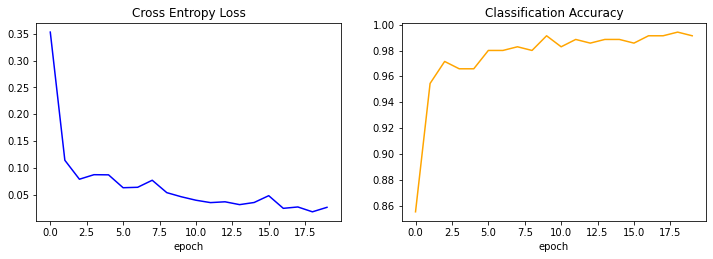

In [14]:
# GRAFICANDO resultados
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(12, 8)

# plot loss
plt.subplot(2,2,1)
plt.title('Cross Entropy Loss')
plt.xlabel("epoch")
plt.plot(history.history['loss'], color='blue', label='train')

# plot accuracy
plt.subplot(2,2,2)
plt.title('Classification Accuracy')
plt.xlabel("epoch")
plt.plot(history.history['accuracy'], color='orange', label='train')

## **SECCIÓN IV - EVALUACIÓN DE LA RED NEURONAL ARTIFICIAL (CNN)**
---

**Evaluación vía 'evaluate_generator':**

In [15]:
# Accuraccy del Test (Usar este valor como referencial solamente https://github.com/keras-team/keras/issues/6499)
eval = model.evaluate_generator(testing_set_imgs, steps=np.ceil(num_imgs_testing/batch_size))

print('\nValidación en Test:')
print("Loss: {:.4}".format(eval[0]))
print("Accuracy: {:.2%}".format(eval[1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Validación en Test:
Loss: 0.02073
Accuracy: 98.86%


**Evaluación vía 'predict_generator' y Matriz de Confusión:**

In [16]:
# Matriz de Confusión
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

THRESHOLD=0.5
testing_set_imgs.reset() #batch_index=0

# Valores de prediccion de nuestro modelo le pasamos (las imagenes que previamente separamos para testing, el numeor de pasos en los que queremos que se lean nuestros datos.)
Y_pred = model.predict_generator(testing_set_imgs, steps=np.ceil(num_imgs_testing/batch_size))
# en base a los valores predichos veremos si el valor es mayor a THRESHOLD 0.5, de ser asi le asignaremos el valor de 1 y en caso de que sea menor le asignaremos 0
# basicamente buscamos el umbral adecuado despues de la funcion RELU de nuestra neurona de salida , podemos ajustar THRESHOLD para obtener mejores valores por ejemplo.
y_pred = np.where(Y_pred >= THRESHOLD, 1, 0)
# print(Y_pred)
# print(y_pred)

cm = confusion_matrix(testing_set_imgs.classes, y_pred)
print("\nMatriz de Confusión:\n")
print(cm)

# print('\nClassification Report:')
# classes_names = ['normal', 'covid19']
# print(classification_report(testing_set_imgs.classes, y_pred, target_names=classes_names))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



Matriz de Confusión:

[[44  0]
 [ 1 43]]


**Visualizando la Matriz de Confusión:**

Matriz de Confusión sin Normalizar


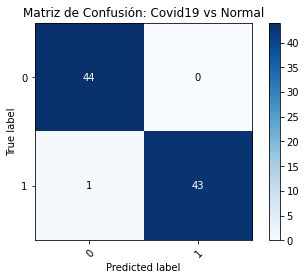

In [18]:
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de Confusión Normalizada'
        else:
            title = 'Matriz de Confusión sin Normalizar'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de Confusión sin Normalizar')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(linewidth=.0)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    plt.show()
    return ax


plot_confusion_matrix(testing_set_imgs.classes, y_pred, normalize=False,title="Matriz de Confusión: Covid19 vs Normal")

**Métricas de la Matriz de Confusión:**

In [19]:
# Métricas (https://en.wikipedia.org/wiki/Confusion_matrix)
TN, FP, FN, TP = cm.ravel()

exactitud = (TP + TN)/(TP + TN + FN + FP)
sensitividad = TP / (TP + FN)
especificidad = TN / (TN + FP)
prevalencia = np.sum(testing_set_imgs.classes)/len(testing_set_imgs.classes)

print("\nMétricas:\n")
print("Exactitud: {:.2%}".format(exactitud))
print("Sensitividad: {:.2%}".format(sensitividad))
print("Especificidad: {:.2%}".format(especificidad))
print("Prevalencia: {:.2%}".format(prevalencia))

# ROC Curve
AUC = roc_auc_score(testing_set_imgs.classes, y_pred)
print("AUCROC: {:.2%}".format(AUC))


Métricas:

Exactitud: 98.86%
Sensitividad: 97.73%
Especificidad: 100.00%
Prevalencia: 50.00%
AUCROC: 98.86%


## **SECCIÓN V - GUARDANDO LA RED NEURONAL ARTIFICIAL EN DISCO**
---

**Guardando modelo en disco:**

In [20]:
# Guardando Arquitectura y Pesos como archivos diferentes
model_json = model.to_json()
with open(project_folder + "/output/covid19_model_config.json","w") as json_file:
  json_file.write(model_json)

model.save_weights(project_folder + "/output/covid19_model_weights.h5")
print("Modelo guardado en disco ...")

Modelo guardado en disco ...


In [21]:
# Cuardando como un único archivo
model.save(project_folder + "/output/covid19_model_full.h5")
print("Modelo guardado en disco ...")

Modelo guardado en disco ...


## **SECCIÓN VI - CARGANDO LA RED NEURONAL ARTIFICIAL EN DISCO Y REALIZANDO PREDICCIONES**
---

**Cargando modelo de disco:**

In [22]:
# Cargando modelo desde el disco
from keras.models import load_model
# load model
loaded_model = load_model(project_folder + "/output/covid19_model_full.h5")
# summarize model
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1921000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 20,243,985
Trainable params: 1,922,001
Non-trainable params: 18,321,984
_________________________________________________________________


**Realizando predicciones:**

Image type: <class 'PIL.Image.Image'>
Image size: (224, 224)


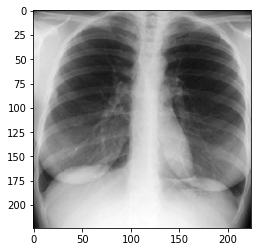

In [36]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import urllib.request

# Cargando imagen a predecir: 
# https://radiologyassistant.nl/chest/covid-19-ct-findings-in-25-patients
#URL_image_rx_test = 'https://radiologyassistant.nl/assets/x.jpg'
# http://www.meddean.luc.edu/lumen/meded/medicine/pulmonar/cxr/atlas/cxratlas_f.htm
URL_image_rx_test = 'http://www.meddean.luc.edu/lumen/meded/medicine/pulmonar/cxr/atlas/images/71bl.jpg'

with urllib.request.urlopen(URL_image_rx_test) as url:
   with open('temp.jpg', 'wb') as f:
       f.write(url.read())
image_test = 'temp.jpg'

# load an image in PIL format
image_to_predict = image.load_img(image_test, target_size=(img_width, img_height))
print('Image type:',type(image_to_predict))
print('Image size:',image_to_predict.size)
plt.imshow(image_to_predict)
plt.show()

In [37]:
# Procesando la imagen
test_image = image.img_to_array(image_to_predict) # Imagen como NumPy array
test_image = np.expand_dims(test_image, axis = 0) # Reshaping de (w,h,c) --> (1,w,h,c)
test_image = test_image.astype('float32')         # Valores de [0-255] --> [0.0-255.0]
test_image /= 255                                 # Valores en [0.0-1.0]

# Prediction
output = loaded_model.predict(test_image)[0][0]
print(output)

0.75235623


In [35]:
# Resultados
prediction = 1 if (output >= THRESHOLD) else 0

CLASSES = ['Normal', 'Covid19+']

ClassPred = CLASSES[prediction]
ClassProb = output

print("Pedicción:", ClassPred)
print("Prob: {:.2%}".format(ClassProb))

Pedicción: Covid19+
Prob: 99.88%
